In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier

In [82]:
df= pd.read_csv("C:\\Users\\ASUS\\Documents\\Data Analysis\\AB_NYC_2019.csv")

# Information about each variable within the dataset:


# Id: Listing ID Number
# Name: Name of the listing
# host_id: Customer’s Id
# host_name: Customer’s Name 
# neighbourhood_group: location
# neighbourhood: area
# latitude: latitude coordinates
# longitude: longitude coordinates
# room_type: listing room types/space types 
# price : price in dollars
# minimum_nights: number of nights spent by the customer
# number_of_reviews: total number of reviews given by the customer
# last_review : shows the date when the review was last submitted by the customer
# reviews_per_month: Percentage of reviews given per month
# calculated_host_listings_count: number of bookings done by the customer
# availability_365: shows information about geographic availability of the listings/rented apartments/villas.

In [83]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [84]:
# Our next step is to find out whether the data contains any missing values:
df.isnull().sum()
# the below table shows us that there are some missing values under name, host_name, last_review and reviews_per_month columns.
# Hence, those missing values needs to be treated and the data needs to be cleaned here after.
# As such we are going to drop the name, host_name and last_review going forward, 
# so we will only concentrate on having the na/missing values treated for reviews_per_month column
# as reviews_per_month is a numerical variable.

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

# Starting with Data Cleaning :

In [85]:
# Treating the missing values within the dataset:
mean = df['reviews_per_month'].mean()
df['reviews_per_month'].fillna(mean, inplace= True)
# Last review cannot be treated in the same way as the data contains a date which needs to be treated seperately,
# however the last review will get deleted from our analysis as we are trying to predict the price variable anyway.
# As reviews_per_month is a float variable, we need to have it converted to integers:
df['reviews_per_month'] = df['reviews_per_month'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

Text(0.5, 1.0, 'Correlation Matrix')

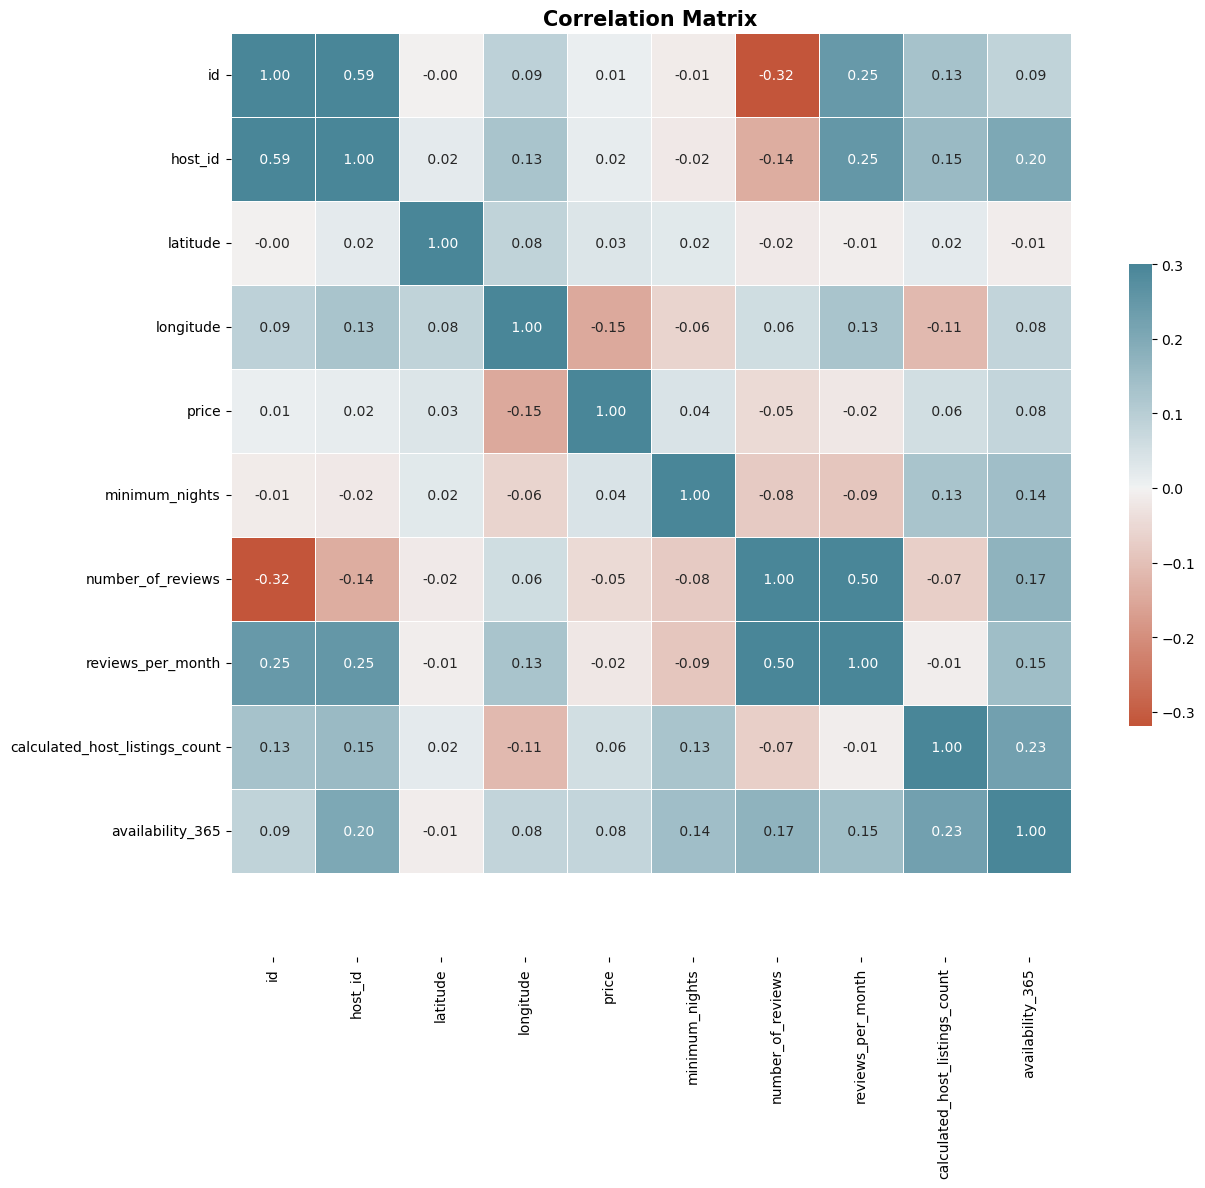

In [86]:
# Correlation table can be created and the Pearson method will be used:
plt.figure(figsize=(15,12))
palette = sns.diverging_palette(20, 220, n=256)
corr= df.corr(method = 'pearson')
sns.heatmap(corr, annot= True, fmt= " .2f", cmap=palette, vmax = .3, center = 0,
            square=True, linewidths= .5, cbar_kws={"shrink": .5}).set(ylim=(11, 0))
plt.title("Correlation Matrix", size = 15, weight = 'bold')

# Observations from Correlation Table :
# The features were not found to be co related to each other, 
# in other words, neither of the features had a significant impact within each other.

# Defining Our Variable of Interest:

In [87]:
# We now need to define the features we are interested to proceed with our analysis:
df2 = df.drop(['id','name','host_id','host_name','latitude','longitude','last_review','calculated_host_listings_count','number_of_reviews'], axis=1)
df2.isnull().sum()
# Voila! We got rid of the na values.
df2.describe(include="all")
# Here, we can observe that the maximum price goes to 10,000 dollars, and average being 142 dollars and 33 cents.
# We are trying to find if there is any relationship between the following:
# 1.) price and reviews_per_month
# 2.) price and availability_365,
# 3.) price and minimum_nights,
# 4.) price and shared rooms, etc.
# We will also check for multi-collinearity(or if the selected features do influence/affect each other in any way possible).

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,reviews_per_month,availability_365
count,48895,48895,48895,48895.000000,48895.000000,48895.000000,48895.000000
unique,5,221,3,NaN,NaN,NaN,NaN
top,Manhattan,Williamsburg,Entire home/apt,NaN,NaN,NaN,NaN
freq,21661,3920,25409,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,152.720687,7.029962,1.011842,112.781327
std,NaN,NaN,NaN,240.154170,20.510550,1.445723,131.622289
min,NaN,NaN,NaN,0.000000,1.000000,0.000000,0.000000
25%,NaN,NaN,NaN,69.000000,1.000000,0.000000,0.000000
50%,NaN,NaN,NaN,106.000000,3.000000,1.000000,45.000000
75%,NaN,NaN,NaN,175.000000,5.000000,1.000000,227.000000


# Data Transformation (Data Conversion):

In [88]:
df2.room_type.unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [89]:
# Similarily, we converted the room_type into numerical variables as well:
def room_type(x):
    if x == 'Private room':
        return 1
    if x == 'Entire home/apt':
        return 2
    if x == 'Shared room':
        return 3 
    
df2['room_type'] = df2['room_type'].apply(room_type)

# Checking for Linearity:

Text(0.5, 1.0, 'Price vs Neighbourhood vs Reviews')

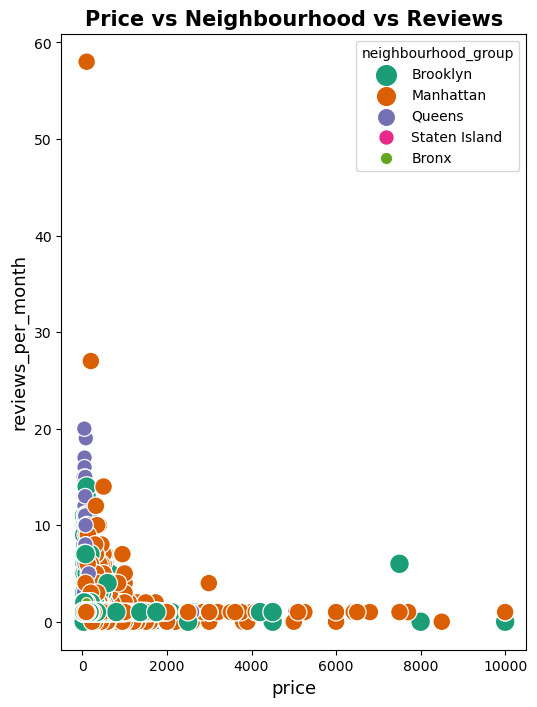

In [90]:
# Scatterplot to find out whether the price influences the reviews_per_month variable:
plt.figure(figsize=(6,8))
sns.scatterplot(x ='price',y='reviews_per_month',hue ="neighbourhood_group",size = "neighbourhood_group",sizes =(50,200),palette ="Dark2", data = df2)
# hence there is no relationship in between price and reviews_per_month.
# Customers paying more were found be giving lesser number of reviews a month.
# On the contrary, customers paying less were found to be giving more number of reviews.
# There are one to two outliers maximum found in the graph below.
# Naming the daigram :
plt.xlabel("price", size = 13)
plt.ylabel("reviews_per_month", size = 13)
plt.title("Price vs Neighbourhood vs Reviews", size = 15, weight = "bold")

Text(0.5, 1.0, 'Room_type vs Price vs Neighbouring_Group')

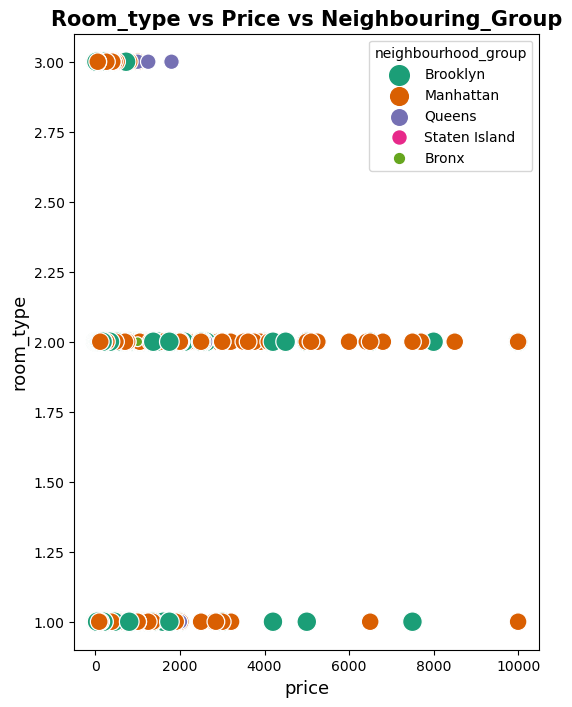

In [91]:
plt.figure(figsize=(6,8))
sns.scatterplot(x ='price', y = 'room_type', hue ="neighbourhood_group", size ="neighbourhood_group", sizes = (50,200), palette ="Dark2", data=df2)
# Naming the scatterplot daigram :
plt.xlabel("price", size = 13)
plt.ylabel("room_type", size = 13)
plt.title("Room_type vs Price vs Neighbouring_Group", size = 15, weight= "bold")

# Observation drawn by the scatterplot daigram:
# the price range is found to be higher for a private room or entire home/apt but only for Brooklyn and Manhattern locations,
# In case of shared rooms, the price range was observed to be around 2000 dollars only for Queens location.
# Manhatten and Brooklyn were found to be the most expensive locations when it comes to booking vacations with Airbnb.

Text(0.5, 1.0, 'Price vs Minimum Nights vs Neighbourhood Groups')

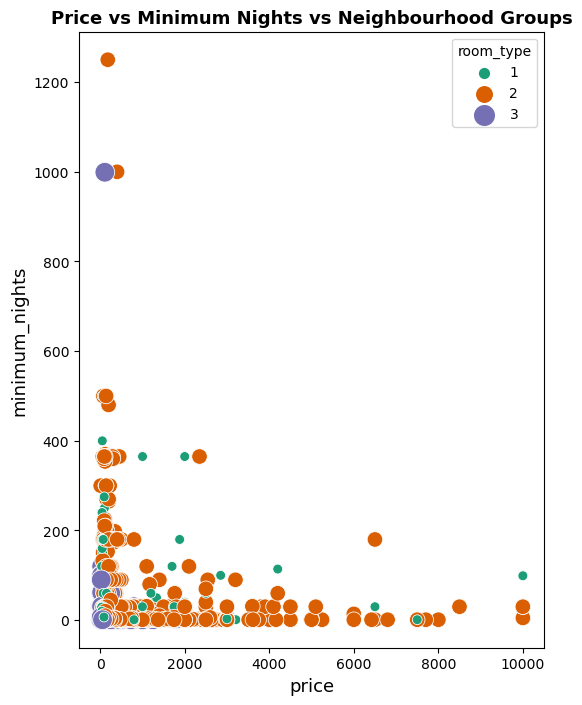

In [92]:
# Now we will plot the daigram for minimum_nights in a similar way:
plt.figure(figsize=(6,8))
sns.scatterplot(x = "price",y ="minimum_nights",hue ="room_type",size ="room_type",sizes =(50,200),palette="Dark2",data=df2)
# the minimum number of nights are going upto 1200, so we need to trim atleast 50 percent of the data to get rid of these three outliers.
# There are total three outliers for Brooklyn location who spend above 1000 to 1200 nights while booking for entire apartment and shared rooms.
plt.xlabel("price", size = 13)
plt.ylabel("minimum_nights", size = 13)
plt.title("Price vs Minimum Nights vs Neighbourhood Groups", size = 13, weight = "bold")

Text(0.5, 1.0, 'Price vs Availability vs Neighbourhood Groups')

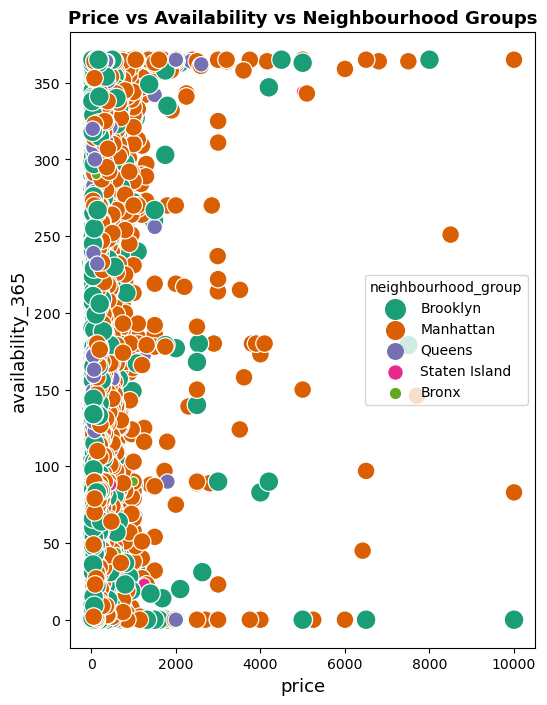

In [93]:
# Our last section of observation will be availability_365 :
plt.figure(figsize=(6,8))
sns.scatterplot(x="price",y="availability_365",hue="neighbourhood_group",size="neighbourhood_group",sizes=(50,200),palette= "Dark2", data=df2)
# Price increases availability as per geographical(demographical area) decreases.
# We can observe here that there are total five outliers, for both Brooklyn and Manhatten with a price range of 8000 to 10000.
plt.xlabel("price", size = 13)
plt.ylabel("availability_365", size = 13)
plt.title("Price vs Availability vs Neighbourhood Groups", size = 13, weight = "bold")

# Trimming the Dataset/Dealing with Outliers:

# We will now use the Quantile Regression to analyse the distribution of the variate observations. 
# Quantile is the point in a data distribution or a percentile that divides a variable into 100 equal places.
# for instance, the middle value of such data is called the median,middle quantile or 50th percentile.
# Quantile Regression determines the median of a set of data accross a distribution based on variables within that distribution.
# Quantile Regression is highly effective as compared to linear regression while dealing with data containing outliers.
# There are other vital reasons on why to choose the Quantile Regression to analyse over Linear Regression:
# 1.) When linear regression assumption are meeting up with each other, for ex., data points showing a heteroscedasticity nature.
# 2.) When you have outliers in your data sample.
# 3.) To determine the median of a quantile within a dataset.
# 4.) When the error variables make your outcome variable spike up.
# 5.) When you have abnormal residuals.

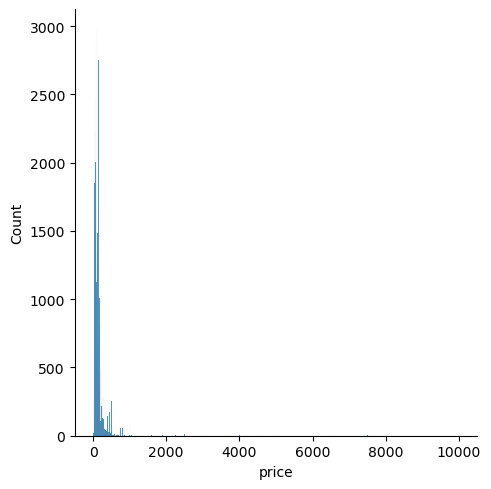

In [94]:
# As we can see that the maximum value is extremely high, pointing towards the outliers, which is why we need to check for 
# probability distribution function (i.e., PDF) :
sns.displot(df2['price'])
# Here, we can see that the graph shows an exponential distribution curve, 
# i.e., the graph shows a positive skewness.

# However, we can see in the above table while trying to describe the features, 
# the maximum value for price goes up to 10,000(an outlier), 
# minimum_nights goes upto 1250, 
# number_of_reviews goes upto 629,
# availability 365 goes up to 365, etc.
# Therefore, we need to trim the data to get rid of the outliers.
# Outliers are observations that lie mostly outside of the third quartile range(75% of the data), appearing far away from majority of data points.

# Dealing with Outliers:

<AxesSubplot:xlabel='price', ylabel='Count'>

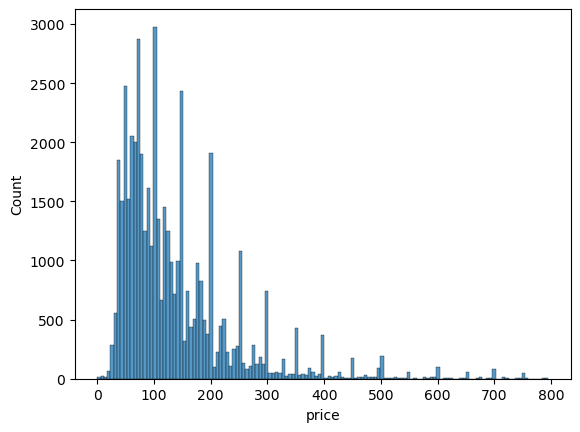

In [95]:
# Here, we can try to use the regression analysis.
# One way to deal with outliers is to remove the top 1 % of the data from the price column.
# We will try to keep the data below 99% and this is how we can eliminate the outliers.
# We create a new variable which is q and assign the quantile function in order to get rid of the top 1% of the data:
q = df2['price'].quantile(0.99)
# Now that we created the q, we can create a new variable by forming a new dataset with only 99% of the dataset under price col.
df_99percent_price = df2[df2['price']<q]
# here, df_99percent_price was created and assigned only the rest 99% of the top, trimming the top 1% eliminating the outliers.
# Plotting the new created price range will give us a better idea of how the new 99 percent data is distributed on the graph:
df_99percent_price.describe(include = "all")
sns.histplot(df_99percent_price['price'])
# Now you can observe the distribution shows positive skewness still, 
# however, the price is now mostly found to be distributed in between 0 to 800 dollars, eliminating the outlier.

<AxesSubplot:xlabel='reviews_per_month', ylabel='Count'>

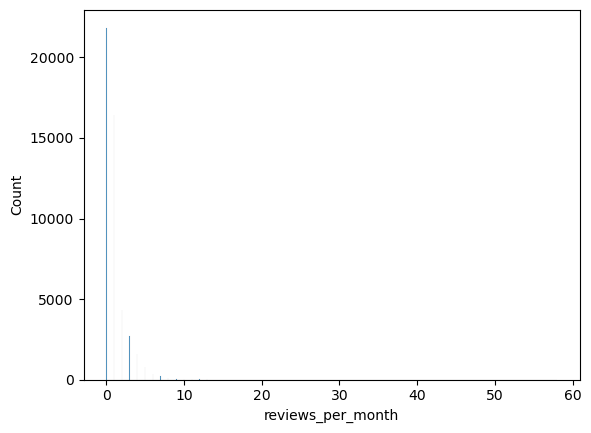

In [96]:
sns.histplot(df_99percent_price['reviews_per_month'])
# Below graph showing an exponential curve or postive skewness, which needs to be treated in a similar procedure as we did with price.

<AxesSubplot:xlabel='reviews_per_month', ylabel='Count'>

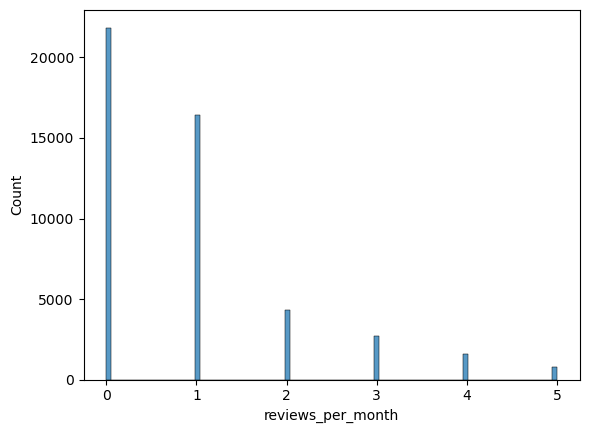

In [97]:
# Similarily, we will try to trim the data for the rest of the selected columns, 
# i.e., minimum_nights, number_of_reviews, availability_365, etc.
# We can see that the data points are quite distributed upto 629, 
# which is why we need to trim the top 1% of data to get rid of the outliers.
# Let's create another variable,p, so we can use the quantile function once again :
p = df_99percent_price['reviews_per_month'].quantile(0.99)
df_99percent_reviews = df_99percent_price[df_99percent_price['reviews_per_month']<p]
# Now we will plot the newly created data, df_99percent_reviews using sns:
sns.histplot(df_99percent_reviews['reviews_per_month'])

C:\Users\ASUS\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='minimum_nights', ylabel='Density'>

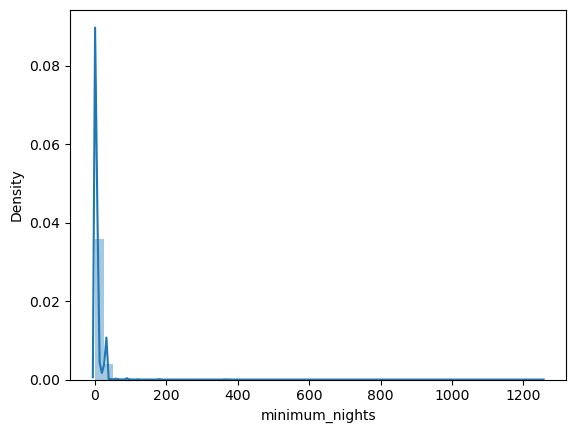

In [98]:
# We need to also exclude the outlier for minimum_nights:
sns.distplot(df_99percent_reviews['minimum_nights'])
# Outliers are somewhere at 1200.

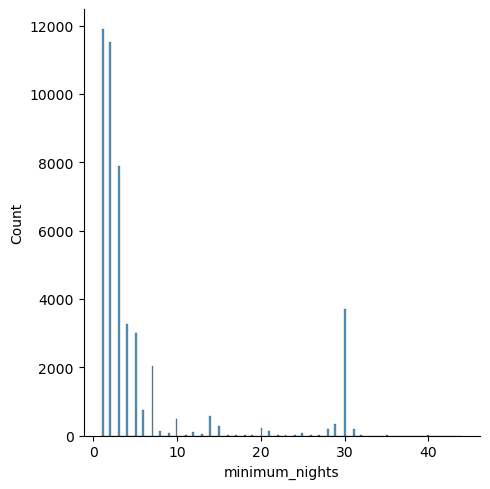

In [99]:
# As we have discussed, we need to trim the minimum_nights dataset,
# since there are only three outliers from Brooklyn location to take care of.
y = df_99percent_reviews['minimum_nights'].quantile(0.99)
df_99percent_minimum_nights = df_99percent_reviews[df_99percent_reviews['minimum_nights']<y]
sns.displot(df_99percent_minimum_nights['minimum_nights'])
# Removal of top 1% of data has caused us to get the maximum no of minimum nights upto 30.
# for an avg mean of 5, 30 is still acceptable.

<AxesSubplot:xlabel='availability_365', ylabel='Count'>

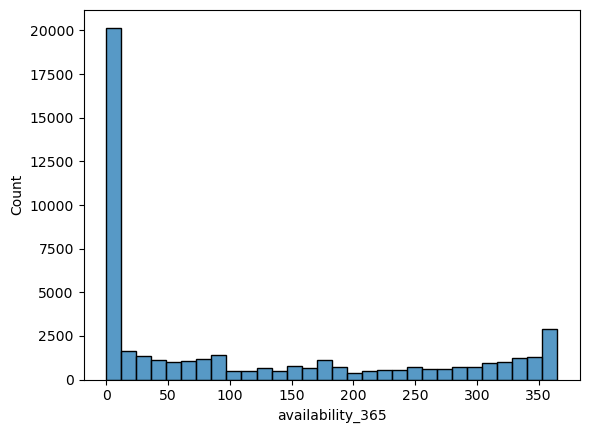

In [100]:
# Let's trim the data for availability_365 as well:
sns.histplot(df_99percent_minimum_nights['availability_365'])
# The distribution of the data is well beyond 350, which is 365.
# So here, the availability as per geographical data is 365 which refers to room types being available for that particular year.
# We will only trim the top 1%, so let's start.

<AxesSubplot:xlabel='availability_365', ylabel='Count'>

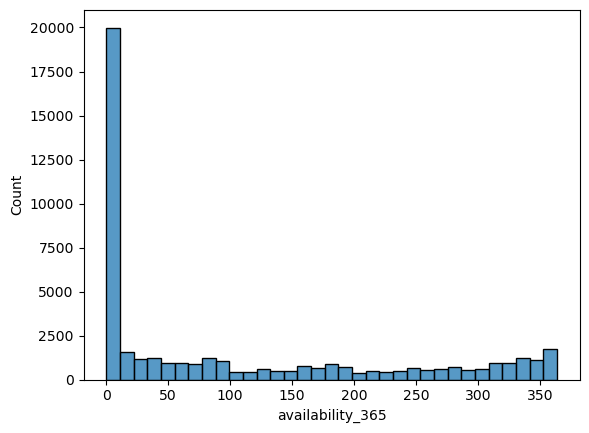

In [101]:
x = df_99percent_minimum_nights['availability_365'].quantile(0.99)
df3 = df_99percent_minimum_nights[df_99percent_minimum_nights['availability_365']<x]
sns.histplot(df3['availability_365'])
# In this case, if we remove the top 1% of the dataset in order to get rid of the outliers, 
# we will be able to get information if there is any linearity between price and availability_365.

In [102]:
df3['neighbourhood_group'].unique()

array(['Manhattan', 'Brooklyn', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [103]:
# As we are going to take "neighbourhood_group" also into consideration,therefore,we need to have it converted in order to interpret it:
def neighbourhood_group(x):
    if x == 'Brooklyn':
        return 1
    if x == 'Manhattan':
        return 2
    if x == 'Queens':
        return 3
    if x == 'Staten Island':
        return 4
    if x == 'Bronx':
        return 5

df3['neighbourhood_group'] = df['neighbourhood_group'].apply(neighbourhood_group)
df3['neighbourhood_group'].unique()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9000\2343817848.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['neighbourhood_group'] = df['neighbourhood_group'].apply(neighbourhood_group)


array([2, 1, 3, 4, 5], dtype=int64)

In [104]:
# Now that our data is cleaned and ready to analyze, we can now create a new variable named data_cleaned and set up the index:
data_cleaned = df3.reset_index(drop=True)
data_cleaned.head()

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,reviews_per_month,availability_365
0,2,Midtown,2,225,1,0,355
1,1,Clinton Hill,2,89,1,4,194
2,2,East Harlem,2,80,10,0,0
3,2,Murray Hill,2,200,3,0,129
4,2,Hell's Kitchen,1,79,2,3,220


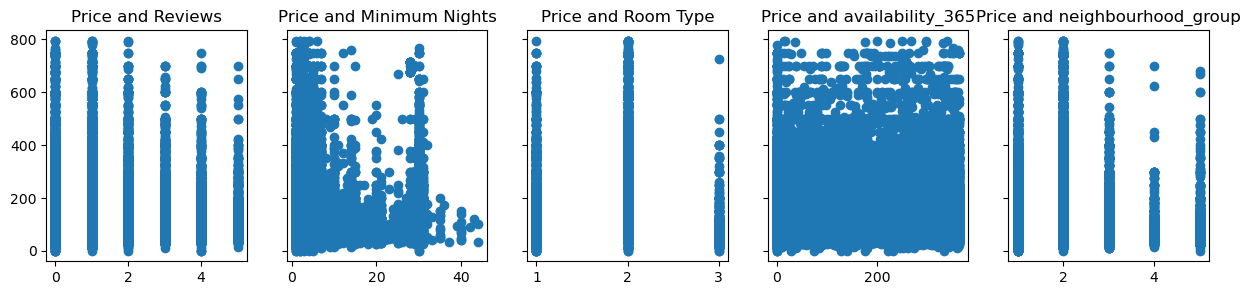

In [105]:
# Now its time for plotting the graph.
# In order to find whether the new transformed data is showing some sort of 
# co-relation in between the x (independent) and y (target) features, we have created three plots showing three axis:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, sharey = True, figsize=(15,3))
ax1.scatter(data_cleaned['reviews_per_month'], data_cleaned['price'])
ax1.set_title('Price and Reviews')
ax2.scatter(data_cleaned['minimum_nights'], data_cleaned['price'])
ax2.set_title('Price and Minimum Nights')
ax3.scatter(data_cleaned['room_type'], data_cleaned['price'])
ax3.set_title('Price and Room Type')
ax4.scatter(data_cleaned['availability_365'], data_cleaned['price'])
ax4.set_title('Price and availability_365')
ax5.scatter(data_cleaned['neighbourhood_group'], data_cleaned['price'])
ax5.set_title('Price and neighbourhood_group')
plt.show()

<AxesSubplot:xlabel='price', ylabel='Count'>

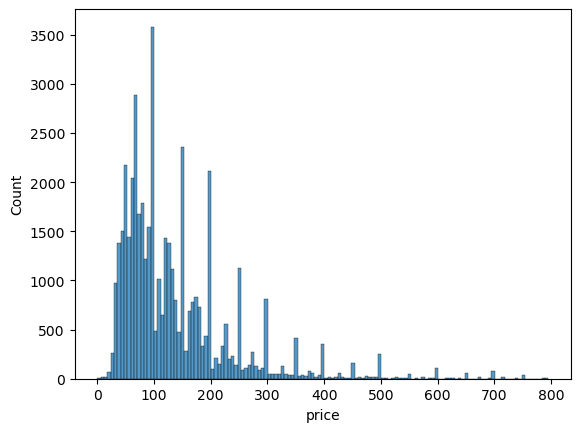

In [106]:
# The results of the above plots shows us that the features show that there is no relation in between each other.
# Therefore, we now have to use the log transformation in order to have the data points come closer to each other:
sns.histplot(data_cleaned['price'])
# As per the graph, the data points are distributed in an exponential distribution curve.

# Log Transformation

# Log Transformation will make the data conform to normality which, in turn, will reduce the skewness for the target variable(price).
# The above sns graph shows non linearity characteristics, which is why, we are going to use log transformation to have the power of the observations increased.
# This will help us to make easier interpretation and better statistical analysis.

In [107]:
data_cleaned['log_price'] = np.log(data_cleaned.price+1)
data_cleaned
# Since division by zero could have given us a problem going formward, therefore, log+1 would be better.

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,reviews_per_month,availability_365,log_price
0,2,Midtown,2,225,1,0,355,5.420535
1,1,Clinton Hill,2,89,1,4,194,4.499810
2,2,East Harlem,2,80,10,0,0,4.394449
3,2,Murray Hill,2,200,3,0,129,5.303305
4,2,Hell's Kitchen,1,79,2,3,220,4.382027
...,...,...,...,...,...,...,...,...
45972,1,Bedford-Stuyvesant,1,70,2,1,9,4.262680
45973,1,Bushwick,1,40,4,1,36,3.713572
45974,2,Harlem,2,115,10,1,27,4.753590
45975,2,Hell's Kitchen,3,55,1,1,2,4.025352


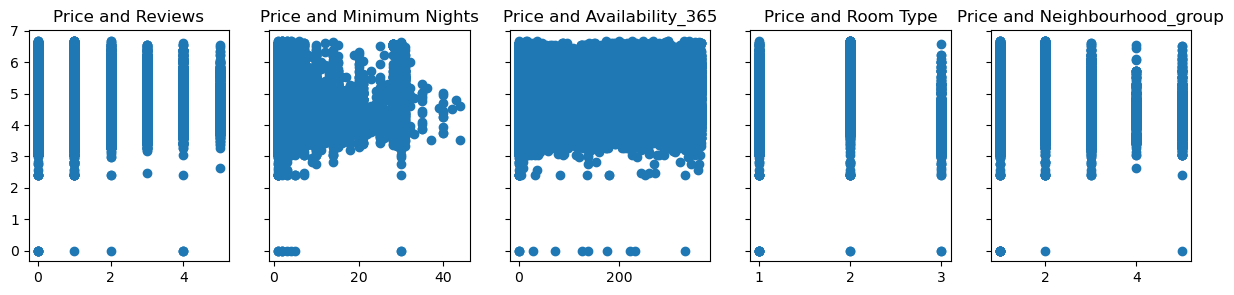

In [108]:
# Once we create an additional column for log_price, it is time for us to incorporate the same to form the subplots:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, sharey = True, figsize = (15,3))
ax1.scatter(data_cleaned['reviews_per_month'],data_cleaned['log_price'])
ax1.set_title('Price and Reviews')
ax2.scatter(data_cleaned['minimum_nights'],data_cleaned['log_price'])
ax2.set_title('Price and Minimum Nights')
ax3.scatter(data_cleaned['availability_365'],data_cleaned['log_price'])
ax3.set_title('Price and Availability_365')
ax4.scatter(data_cleaned['room_type'], data_cleaned['log_price'])
ax4.set_title('Price and Room Type')
ax5.scatter(data_cleaned['neighbourhood_group'], data_cleaned['log_price'])
ax5.set_title('Price and Neighbourhood_group')
plt.show()
# As we can see that even after getting the logorithmic price included in our data, we can still see that none of the features 
# shows a strong relationship with the newly created log_price or 
# in other words, the regressor variables doesn't affect the target variable, log of price values.
# any change in the data points within any independent variables doesn't affect the target variable, log_price column.

<AxesSubplot:xlabel='log_price', ylabel='Count'>

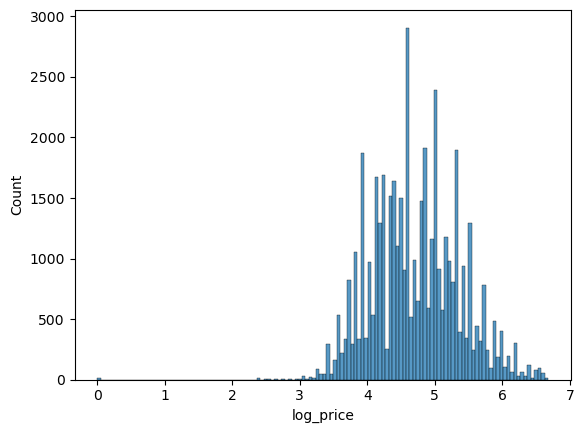

In [109]:
sns.histplot(data_cleaned['log_price'])
# here we can see that the data points are scattered in a more or less normal distribution curve.
# Indicating a good fit showing that normality is a reasonable approximation.
# However, the above graph has shown us that none of the regressor variables has any affect on log_price column/logorithmic price.

# Now we will start with checking for multi-collinearity in between the regressor variables.
# If multi-collinearity exists, it might create a problem while ranking the most affecting variable against the log_price column.

In [110]:
data_cleaned.head()

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,reviews_per_month,availability_365,log_price
0,2,Midtown,2,225,1,0,355,5.420535
1,1,Clinton Hill,2,89,1,4,194,4.499810
2,2,East Harlem,2,80,10,0,0,4.394449
3,2,Murray Hill,2,200,3,0,129,5.303305
4,2,Hell's Kitchen,1,79,2,3,220,4.382027


In [111]:
# In order to check for multi-collinearity, we can make the use of VIF (Variance Inflation Factor):
# We have already called the package before, so we will straight away jump into creation of object and start assigning variables:
Variables = data_cleaned[['room_type','minimum_nights','reviews_per_month','availability_365']] # to check if collinearity exists.
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(Variables.values, i) for i in range(Variables.shape[1])]
vif["Features"] = Variables.columns
Variables.shape[1]

4

In [112]:
vif
# As we can see from the below vif table, we can observe that multi-colinearity doesn't exists in between the features.

,VIF,Features
0,2.297031,room_type
1,1.648193,minimum_nights
2,1.680358,reviews_per_month
3,1.852940,availability_365


In [113]:
data_cleaned1 = data_cleaned.drop(['price','neighbourhood'], axis = 1)
data_no_mutlicolinearity = data_cleaned1
# data_no_mutlicolinearity.info()
# Before moving on, we need to have the log_price converted into an integer so the data can get scaled properly.
data_cleaned1.tail()

,neighbourhood_group,room_type,minimum_nights,reviews_per_month,availability_365,log_price
45972,1,1,2,1,9,4.262680
45973,1,1,4,1,36,3.713572
45974,2,2,10,1,27,4.753590
45975,2,3,1,1,2,4.025352
45976,2,1,7,1,23,4.510860


# Starting with the Prediction:

In [114]:
# We need to now get the feature columns defined to start with the training and testing data split:
X = data_cleaned1.drop(['log_price'], axis = 1)
Y = data_cleaned1.log_price

In [115]:
# Check the heads of two variables defined:
X.isnull().sum()
#Y
# Succesfully segregated both the variables.

neighbourhood_group    0
room_type              0
minimum_nights         0
reviews_per_month      0
availability_365       0
dtype: int64

In [116]:
# Starting with Standardizing the Variables before splitting it into train & test dataset:
scaler = StandardScaler(with_mean=False)
# Fitting the data with an intent to scale it:
scaler.fit(X)

StandardScaler(with_mean=False)

In [117]:
# Next step is to transform the data to get a standardized dataset:
X_Scaled = scaler.transform(X)

In [118]:
# Splitting the data into training and testing dataset:
x_train, x_test, y_train, y_test = train_test_split(X_Scaled, Y, test_size = 0.3, random_state= 13)

In [119]:
reg = LinearRegression()

In [120]:
reg.fit(x_train,y_train)

LinearRegression()

In [121]:
# Now we will try to get the prediction results by using reg.score:
reg.score(x_train, y_train)
# As we can see the prediction coming very less as we are conducting our analysis on non linear data.

0.26112371921631805

In [122]:
# No we will try with the test dataset:
reg.score(x_test, y_test)
# Same happens with the testing dataset.

0.26891813921214724

In [123]:
# Once you have fitted the training data to linear regression, we will now create y_pred(to predict the training data):
y_pred = reg.predict(x_train)

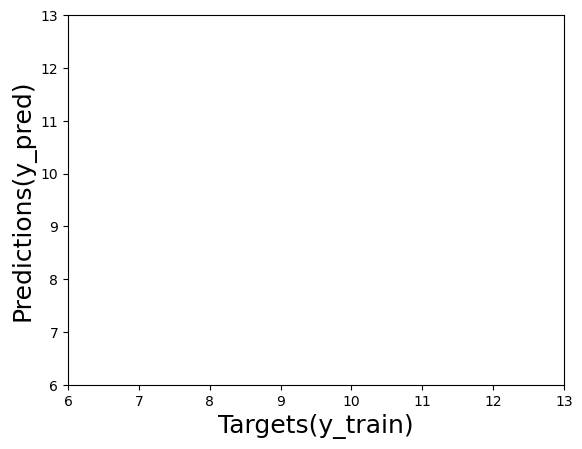

In [124]:
# Plot a scatter daigram with the training dataset results:
plt.scatter(y_train, y_pred)
plt.xlabel('Targets(y_train)', size = 18)
plt.ylabel('Predictions(y_pred)', size = 18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

In [125]:
y_pred1 = reg.predict(x_test)

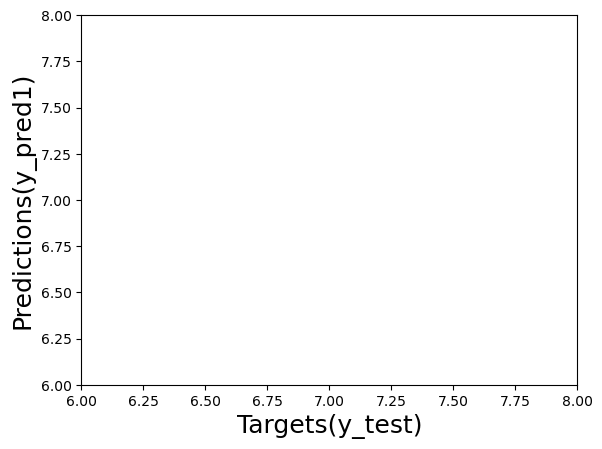

In [126]:
plt.scatter(y_test,y_pred1)
plt.xlabel('Targets(y_test)', size = 18)
plt.ylabel('Predictions(y_pred1)', size = 18)
plt.xlim(6,8)
plt.ylim(6,8)
plt.show()

C:\Users\ASUS\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Residuals.PDF')

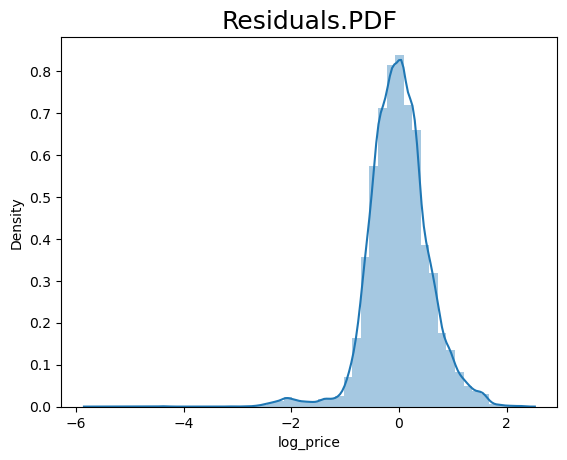

In [127]:
# Lets plot the residuals:
Residuals = y_train-y_pred
sns.distplot(Residuals)
plt.title("Residuals.PDF", size = 18)

In [128]:
# Now its time to plot the reg_summary results by including the intercept and the coefficient:
reg.intercept_

3.7772879019976

In [129]:
reg.coef_

array([-0.01890009,  0.32708995, -0.02313717, -0.01319534,  0.05509985])

In [130]:
reg_summary = pd.DataFrame(X.columns.values, columns = ['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

,Features,Weights
0,neighbourhood_group,-0.018900
1,room_type,0.327090
2,minimum_nights,-0.023137
3,reviews_per_month,-0.013195
4,availability_365,0.055100


# Observation:
# You can observe positive values only for room_type and availability_365.
# This means with a change in room_type and availability ratios, price gets affected.
# As we know that if rooms will not be available, the customers won't be able to book the rooms.
# Here, in the case of analysing this dataset, we can see that customers mainly book their vacations for an entire apt/private rooms,
# mainly from Manhatten and Brooklyn, etc.
# Entire apt/home and private rooms have limited availability issues as well.

# Observations:
# There are some negative results for some of the features,neighbouring_group,minimum_nights and reviews_per_month, etc.
# These features are not found to be affecting the target, log_price, which is why its showing the result in minus.

C:\Users\ASUS\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Weights', ylabel='Density'>

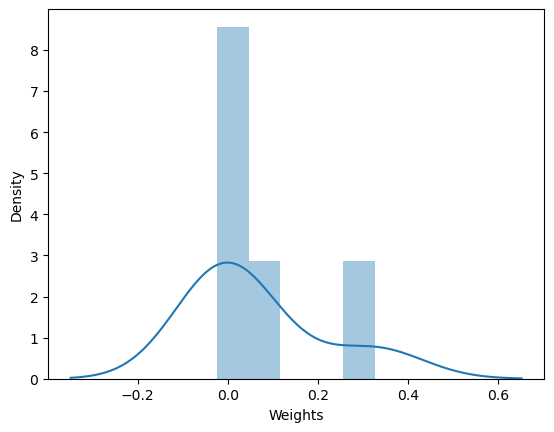

In [131]:
sns.distplot(reg_summary['Weights'])

In [132]:
# We will try to carry out some predictions on non linear dataset:
df_pf = pd.DataFrame((y_pred1), columns=['Predictions'])
df_pf.tail()

,Predictions
13789,4.932959
13790,4.890286
13791,4.936538
13792,5.000733
13793,4.407612


In [133]:
# In order to find the actual predictions, we will use exponential function to get the exact predictions,
df_pf = pd.DataFrame(np.exp(y_pred1), columns = ['Predictions'])
df_pf.head(5)
# Initially, while applying the log function we added 1 so we are now substracting 1 from the predicted values to get the actual predicted values.

,Predictions
0,77.194765
1,80.696351
2,134.754235
3,143.012837
4,86.097892


In [134]:
y_test = y_test.reset_index(drop = True)

In [135]:
y_test
df_pf['Targets'] = np.exp(y_test)
df_pf

,Predictions,Targets
0,77.194765,61.0
1,80.696351,46.0
2,134.754235,139.0
3,143.012837,242.0
4,86.097892,40.0
...,...,...
13789,138.789599,101.0
13790,132.991634,161.0
13791,139.287238,351.0
13792,148.522014,236.0


In [136]:
df_pf['Residuals'] = df_pf['Targets']-df_pf['Predictions']
df_pf

,Predictions,Targets,Residuals
0,77.194765,61.0,-16.194765
1,80.696351,46.0,-34.696351
2,134.754235,139.0,4.245765
3,143.012837,242.0,98.987163
4,86.097892,40.0,-46.097892
...,...,...,...
13789,138.789599,101.0,-37.789599
13790,132.991634,161.0,28.008366
13791,139.287238,351.0,211.712762
13792,148.522014,236.0,87.477986


In [137]:
df_pf['Differences'] = np.absolute(df_pf['Residuals']/df_pf['Targets']*100)
df_pf

,Predictions,Targets,Residuals,Differences
0,77.194765,61.0,-16.194765,26.548795
1,80.696351,46.0,-34.696351,75.426850
2,134.754235,139.0,4.245765,3.054507
3,143.012837,242.0,98.987163,40.903787
4,86.097892,40.0,-46.097892,115.244730
...,...,...,...,...
13789,138.789599,101.0,-37.789599,37.415445
13790,132.991634,161.0,28.008366,17.396501
13791,139.287238,351.0,211.712762,60.317026
13792,148.522014,236.0,87.477986,37.066943


In [138]:
# Comparing the prediction results with the initial datapoint observations:
df_pf['Initial_Price'] = df2['price']
df_pf
# Predictions are more or less very closer to the actual price range,however, target is deviating from the actual.
# This means there is an underfitting situation, which explains the cause.
# Training dataset is not performing accurate however test data is found to be closer to actual price range.

,Predictions,Targets,Residuals,Differences,Initial_Price
0,77.194765,61.0,-16.194765,26.548795,149
1,80.696351,46.0,-34.696351,75.426850,225
2,134.754235,139.0,4.245765,3.054507,150
3,143.012837,242.0,98.987163,40.903787,89
4,86.097892,40.0,-46.097892,115.244730,80
...,...,...,...,...,...
13789,138.789599,101.0,-37.789599,37.415445,100
13790,132.991634,161.0,28.008366,17.396501,50
13791,139.287238,351.0,211.712762,60.317026,80
13792,148.522014,236.0,87.477986,37.066943,75


# Observations:
# We can experience an underfitting issue, which shows us that training data is not able to predict properly,
# However, the testing dataset is able to make close to accurate predictions.

# We will now move ahead to perform the clustering technique to understand how many optimum number of clusters could be formed out of the given data.
# We also need to find the solution to the existing availability problem.

In [146]:
from sklearn.cluster import KMeans

In [147]:
model=KMeans(n_clusters=4,random_state=9)

In [150]:
model.fit(data_cleaned1)

KMeans(n_clusters=4, random_state=9)

In [152]:
model.predict(data_cleaned1)

array([3, 1, 0, ..., 0, 0, 0])

In [154]:
# Getting group wise summary on the clusters
data_cleaned1['sum1']=model.predict(data_cleaned1) # here sum1 refers to the clusters created based upon the main dataset.

In [155]:
data_cleaned1.groupby('sum1').mean()
# groupby function helped to get the mean (average values) for identifying the types of customers in each of the four clusters.

,neighbourhood_group,room_type,minimum_nights,reviews_per_month,availability_365,log_price
sum1,,,,,,
0,1.678957,1.560331,4.206693,0.618876,5.261501,4.666403
1,1.853536,1.592285,7.039203,1.321311,198.090638,4.797113
2,1.853443,1.529282,4.994703,1.404650,87.347116,4.703727
3,1.926261,1.587156,9.316972,1.067890,322.649656,4.789815


In [156]:
from sklearn.preprocessing import StandardScaler 
# first we have to standardise the data for which had to import the StandardScaler.

In [157]:
scaler= StandardScaler()

In [158]:
scaler.fit(data_cleaned1) # Now that we have standardized the data, the next step would be to transform the data into a numpy array.

StandardScaler()

In [159]:
data_cleaned1_c= scaler.transform(data_cleaned1) 
# in order to get better predictive results we have transformed the main dataset into a standardized one, 
# coverting into a numpy array.

In [160]:
data_cleaned1_c # you can see that the df dataset has transformed into a numpy array.

array([[ 0.26676869,  0.80877457, -0.56470148, ...,  1.9854726 ,
         1.09117748,  1.66956213],
       [-0.92345199,  0.80877457, -0.56470148, ...,  0.71021514,
        -0.32970194, -0.00276436],
       [ 0.26676869,  0.80877457,  0.52004473, ..., -0.8264305 ,
        -0.49229613, -0.8389276 ],
       ...,
       [ 0.26676869,  0.80877457,  0.52004473, ..., -0.61256745,
         0.06193659, -0.8389276 ],
       [ 0.26676869,  2.66914221, -0.56470148, ..., -0.81058879,
        -1.06189379, -0.8389276 ],
       [ 0.26676869, -1.05159307,  0.15846266, ..., -0.64425086,
        -0.31264964, -0.8389276 ]])

In [161]:
model.fit(data_cleaned1_c)

KMeans(n_clusters=4, random_state=9)

In [162]:
model.predict(data_cleaned1_c) # here we are having the predictive values for each customers seperating them into different cluster groups.

array([3, 3, 0, ..., 0, 0, 1])

In [163]:
data_cleaned2=pd.DataFrame(data_cleaned1_c) 

In [164]:
data_cleaned2.columns=data_cleaned1.columns

In [165]:
data_cleaned2.head()

,neighbourhood_group,room_type,minimum_nights,reviews_per_month,availability_365,log_price,sum1
0,0.266769,0.808775,-0.564701,-0.792151,1.985473,1.091177,1.669562
1,-0.923452,0.808775,-0.564701,2.660949,0.710215,-0.329702,-0.002764
2,0.266769,0.808775,0.520045,-0.792151,-0.826431,-0.492296,-0.838928
3,0.266769,0.808775,-0.323647,-0.792151,0.195360,0.910266,0.833399
4,0.266769,-1.051593,-0.444174,1.797674,0.916157,-0.511467,-0.002764


In [ ]:
# Now that we have created a new dataset df2, 
# the next step will be to create clusters for grouping the customers based on their consumption.

In [166]:
data_cleaned2['cluster']=model.predict(data_cleaned1_c)

In [170]:
data_cleaned2.groupby('cluster').mean() # have grouped the customers according to the predictive values for each cluster.

,neighbourhood_group,room_type,minimum_nights,reviews_per_month,availability_365,log_price,sum1
cluster,,,,,,,
0,-0.109020,0.860800,-0.260569,-0.295956,-0.572260,0.549855,-0.572733
1,-0.111506,-1.046134,-0.299003,-0.185802,-0.521949,-0.715033,-0.481648
2,0.066723,0.327346,2.841174,-0.349957,0.908185,0.160598,0.787668
3,0.285053,0.006162,-0.390893,0.836376,1.178114,0.087575,1.174333


In [171]:
data_cleaned3=data_cleaned2.drop(['sum1'], axis=1)

In [172]:
data_cleaned3.head()

,neighbourhood_group,room_type,minimum_nights,reviews_per_month,availability_365,log_price,cluster
0,0.266769,0.808775,-0.564701,-0.792151,1.985473,1.091177,3
1,-0.923452,0.808775,-0.564701,2.660949,0.710215,-0.329702,3
2,0.266769,0.808775,0.520045,-0.792151,-0.826431,-0.492296,0
3,0.266769,0.808775,-0.323647,-0.792151,0.195360,0.910266,0
4,0.266769,-1.051593,-0.444174,1.797674,0.916157,-0.511467,3


In [173]:
# As we have dropped the sum1 and sum2 columns from the dataset, we will now have to create clusters 
# and start grouping the customers into those clusters.

groups=data_cleaned3.groupby('cluster') 

In [174]:
cluster1=groups.get_group(0)
cluster2=groups.get_group(1)
cluster3=groups.get_group(2)
cluster4=groups.get_group(3)

In [175]:
# Now we will try to analyse the groups into which the customers are placed seperately:
# Selected 5 random customers for analysing the ist cluster
# which included a set of customers belonging to Brooklyn(40%) and Manhatten(60%), 
# These customers were found to be booking an entire house/apt and giving fair amount of reviews/feedbacks per month.
# However, these customers stayed for a little longer (for 8-9 nights on an average.)
cluster1.sample(5,random_state=13)

,neighbourhood_group,room_type,minimum_nights,reviews_per_month,availability_365,log_price,cluster
43229,-0.923452,0.808775,-0.444174,1.797674,-0.580884,-0.346945,0
7076,-0.923452,0.808775,0.037935,-0.792151,0.829028,0.468867,0
44447,0.266769,2.669142,-0.564701,3.524224,-0.818510,-0.929914,0
1378,-0.923452,0.808775,-0.203119,0.071124,-0.311575,0.902569,0
40100,2.647210,0.808775,0.158463,0.071124,-0.699697,-0.151752,0


In [176]:
cluster2.sample(5,random_state=13)
# Observations :
# found that 40% of the customers were coming from Manhatten, 40% from Brooklyn and 10% from Queens,
# Minimum nights were on an average found to be around 7-8 nights,
# People spended moderate amounts on rooms. 
# There were no reviews put up by the customers from Queens,
# It has been observed that the customers tend to book low cost apartments for their longer stay.
# Opportunity statement we need to work on - 
# 1) Availability is an issue which should be taken care of for low cost apartments (50,33,etc.)
# 2) Customers from Queens donot tend to submit any reviews. Availability is also zero for them (Main issue),
# 3) Mostly people are coming from Brooklyn and Manhatten and very rarely from Queens, which makes them brand new customers.
# 4) Customers coming from Queens can be the potential ones as they stay for longer period of time (30)
# So if the company pays more attention to the availability part,this can help them achieve higher sales revenue 
#    and even encourage more customers to book their stay in Airbnb from Queens.
# Three advantages:
# 1) New lead generation
# 2) Spreading awareness amongst consumers(in terms of market footprints tapping the potential crowd.)
# 3) Improve customer reviews

,neighbourhood_group,room_type,minimum_nights,reviews_per_month,availability_365,log_price,cluster
24490,-0.923452,-1.051593,-0.444174,0.071124,-0.826431,-1.399379,1
16976,0.266769,-1.051593,-0.082592,-0.792151,-0.810589,-0.020023,1
16211,0.266769,-1.051593,-0.444174,-0.792151,-0.826431,-0.955423,1
45631,1.456989,-1.051593,-0.444174,0.071124,-0.660093,-0.808338,1
23384,0.266769,-1.051593,-0.323647,0.071124,0.987445,-0.230105,1


In [177]:
cluster3.sample(5,random_state=13)
# Observations :
# These customers were mostly coming from Manhatten (10%), Brooklyn (60%), Queens(10%) 
# and were found to be booking the entire house/apt(90%) and private room(10%),
# Number of nights were on an average found to be 8-9 nights,
# Number of reviews were found to be descent.
# These set of customers were found to be spending little higher than usual for an entire house/apt,
# Similarily, we can observe that the customers coming from Queens are giving their feedbacks/reviews in cluster 3 unlike 2,
# Availability is also high for them.
# Hence, it proves that if the company wants to increase the customer base for Queens, they have to keep the rooms available.

,neighbourhood_group,room_type,minimum_nights,reviews_per_month,availability_365,log_price,cluster
39809,1.456989,-1.051593,2.930592,0.071124,1.621113,-1.365461,2
39589,0.266769,0.808775,2.930592,0.071124,1.803293,1.427321,2
39867,-0.923452,-1.051593,2.930592,0.071124,0.298331,-1.118017,2
40067,-0.923452,-1.051593,2.930592,0.071124,-0.398704,-1.831946,2
41402,1.456989,-1.051593,2.930592,0.071124,1.747847,-1.787212,2


In [178]:
cluster4.sample(5,random_state=13)
# Observations :
# These customers were coming from Manhatten (80%) and from Brooklyn (40%),
# Prices were higher as per their stay,
# the price for the entire house/apt is higher as compared to the private rooms,
# Number of reviews per month were quite low for the ones who had an availability issue,
# Opportunity statement being the same as we found in cluster 2,
# However, the customers here were found to be booking entire house /apt for a higher rate.
# This means if there will be availability the company will earn more.
# Availability of rooms should be tracked down to improve sales and reviews.

,neighbourhood_group,room_type,minimum_nights,reviews_per_month,availability_365,log_price,cluster
18528,-0.923452,0.808775,-0.444174,1.797674,1.359725,1.399614,3
6338,-0.923452,-1.051593,0.520045,-0.792151,1.937947,-0.808338,3
36476,0.266769,0.808775,-0.323647,-0.792151,1.771610,1.427321,3
12273,-0.923452,0.808775,-0.323647,2.660949,1.343883,0.615022,3
2413,0.266769,-1.051593,-0.564701,-0.792151,1.613192,-0.077186,3


# Now in order to draw an elbow daigram (to determine the optimal number of clusters) through KMeans clustering method.
# to check which columns/features are relevant to draw the elbow daigram. "

In [179]:
# as the Id and cluster column was not required for drawing the elbow daigram,
# therefore, have used the drop fuction to remove both the columns from the dataset and saved the same by creating a new variable,df3,
data_cleaned4=data_cleaned3.drop(['cluster'],axis=1)

In [180]:
data_cleaned4.head() # here we will consider taking only those features used for the analysis part..

,neighbourhood_group,room_type,minimum_nights,reviews_per_month,availability_365,log_price
0,0.266769,0.808775,-0.564701,-0.792151,1.985473,1.091177
1,-0.923452,0.808775,-0.564701,2.660949,0.710215,-0.329702
2,0.266769,0.808775,0.520045,-0.792151,-0.826431,-0.492296
3,0.266769,0.808775,-0.323647,-0.792151,0.195360,0.910266
4,0.266769,-1.051593,-0.444174,1.797674,0.916157,-0.511467


In [181]:
# Importing the minmaxscaler function to scale the dataset.
from sklearn.preprocessing import MinMaxScaler

In [183]:
# here used the minmaxscaler to transform the data into a standardized one and saved it under the name of data_transformed.
mms = MinMaxScaler()
mms.fit(data_cleaned4)
data_transformed = mms.transform(data_cleaned4)

In [184]:
# it shows that the data_transformed is a numpy array,
data_transformed

array([[0.25      , 0.5       , 0.        , 0.        , 0.97527473,
        0.81150603],
       [0.        , 0.5       , 0.        , 0.8       , 0.53296703,
        0.67366462],
       [0.25      , 0.5       , 0.20930233, 0.        , 0.        ,
        0.65789114],
       ...,
       [0.25      , 0.5       , 0.20930233, 0.2       , 0.07417582,
        0.711658  ],
       [0.25      , 1.        , 0.        , 0.2       , 0.00549451,
        0.60263372],
       [0.25      , 0.        , 0.13953488, 0.2       , 0.06318681,
        0.67531889]])

In [186]:
# Conversion of the numpy array into a DataFrame,
data_transformed=pd.DataFrame(data_transformed, columns=['neighbourhood_group','room_type','price','minimum_nights','reviews_per_month','availability_365'])
data_transformed

,neighbourhood_group,room_type,price,minimum_nights,reviews_per_month,availability_365
0,0.25,0.5,0.000000,0.0,0.975275,0.811506
1,0.00,0.5,0.000000,0.8,0.532967,0.673665
2,0.25,0.5,0.209302,0.0,0.000000,0.657891
3,0.25,0.5,0.046512,0.0,0.354396,0.793956
4,0.25,0.0,0.023256,0.6,0.604396,0.656031
...,...,...,...,...,...,...
45972,0.00,0.0,0.023256,0.2,0.024725,0.638164
45973,0.00,0.0,0.069767,0.2,0.098901,0.555957
45974,0.25,0.5,0.209302,0.2,0.074176,0.711658
45975,0.25,1.0,0.000000,0.2,0.005495,0.602634


In [187]:
# model.inertia will give the within cluster sum of squares distance ()
model.inertia_

174975.27908421797

In [188]:
# Elbow Method to minimise WSS (Within sum of squared distances):
Sum_of_squared_distances = []
K = range (1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

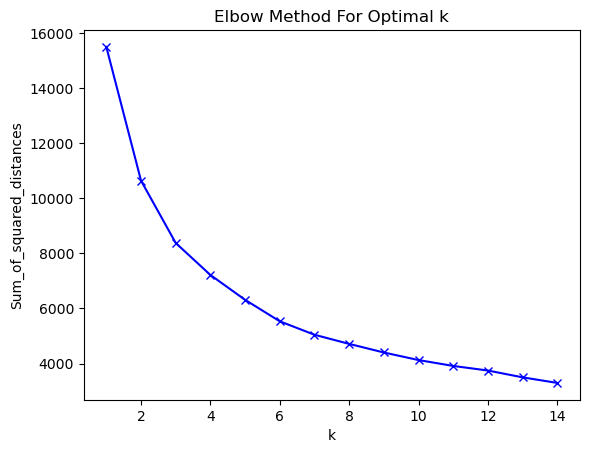

In [189]:
# Plotting the elbow daigram with k(number of clusters) on the x axis and sum of squared distances on the y axis,
# in this case, we have got the k value as 3 as shown below,
# this means that there are possibly four types of customers, 
# Cluster 2 shows that the availability is the main issue for low cost private rooms why customers coming from Queens
# are not providing their feedbacks/reviews,
# Queens customers can be the potential ones to get high sales for low cost private rooms,
# Cluster 3 shows their intent to give fair amount of reviews when the availability was good,
# Cluster 4 however shows a slight different case, 
# where the customers booking an entire house/ apt for higher rates didnt post any reviews due to non availability of rooms,
# Therefore i would like to conclude that the company must have a check on the availability area 
# so that these three things can be achieved :
# Three advantages:
# 1) New lead generation
# 2) Spreading awareness amongst consumers(in terms of market footprints tapping the potential crowd (Queens consumers)).
# 3) Improve customer reviews

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [190]:
# In order to find out the centroids for each of the 4 clusters 
model.cluster_centers_

array([[-0.10874593,  0.86051604, -0.26040757, -0.29717032, -0.57337605,
         0.54996645, -0.57402063],
       [-0.11083816, -1.04613633, -0.29892468, -0.185326  , -0.52149708,
        -0.714865  , -0.48141933],
       [ 0.06641355,  0.32765214,  2.84155652, -0.34985896,  0.90811495,
         0.16074754,  0.78784407],
       [ 0.28337898,  0.00874771, -0.39091707,  0.83594455,  1.17702136,
         0.08850056,  1.17366014]])